# Setup

In [1]:
# Used to read .env files, for access tokens and other secrets or configurations
%load_ext dotenv
%dotenv
import os

In [2]:
from github import Github
import pandas
from matplotlib import pyplot
import numpy
import seaborn

from datetime import datetime, timedelta

In [3]:
# The github token is stored in a .env file next to this notebook in the form "GITHUB_TOKEN = <your token here>"
github = Github(os.getenv("GITHUB_TOKEN"))

# Team Constants

These are things that describe how the team work and are static

## Team Members

In [4]:
sap = github.get_organization('SAP')
def is_company_member(named_user):
    return ('SAP' in (named_user.company or '').upper()) or named_user.login.upper().endswith('SAP') or sap.has_in_members(named_user)

In [5]:
cwa = github.get_organization('corona-warn-app')
team = list(filter(is_company_member, cwa.get_members()))
team

[NamedUser(login="AdnanZiSAP"),
 NamedUser(login="christian-kirschnick"),
 NamedUser(login="christianneu"),
 NamedUser(login="EvgeniiSkrebtcov"),
 NamedUser(login="haosap"),
 NamedUser(login="hilmarf"),
 NamedUser(login="inf2381"),
 NamedUser(login="johanneseschrig"),
 NamedUser(login="johannesrohwer"),
 NamedUser(login="MalteJ"),
 NamedUser(login="marcauberer"),
 NamedUser(login="Marco2907"),
 NamedUser(login="mibrasap"),
 NamedUser(login="michael-burwig"),
 NamedUser(login="mlenkeit"),
 NamedUser(login="PetrusVanHeaven"),
 NamedUser(login="pithumke"),
 NamedUser(login="SebastianWolf-SAP"),
 NamedUser(login="steins-code"),
 NamedUser(login="T-Bendrath"),
 NamedUser(login="tkowark")]

## Sprint Management

In [6]:
# In the following, we will assume that sprints are totally regular, starting with a fixed date.
# The helper functions can of course be adapted to represent, e.g., changes in sprint duration or holiday breaks

start_date_first_sprint = datetime(2020, 4, 27) # It's a monday, development actually started 02.05.2020
sprint_length = timedelta(weeks=2)

def date_to_sprint(date_to_convert):
    return max(0, (date_to_convert - start_date_first_sprint) // sprint_length + 1) # Sprint "0" is everything before the first

def sprint_to_start_date(sprint_to_convert):
    return (start_date_first_sprint + (sprint_to_convert - 1) * sprint_length)

def date_to_sprint_start(date_to_convert):
    return sprint_to_start_date(date_to_sprint(date_to_convert))

## Repos

In [7]:
server_repo = github.get_repo('corona-warn-app/cwa-app-android')
# Let's assume that all developers with less than 5 commits were not active developers
server_contributors = map(lambda stats: stats.author, filter(lambda stats: stats.total >= 5, server_repo.get_stats_contributors()))
server_team = list(filter(is_company_member, server_contributors))
server_team

[NamedUser(login="ChristopherSchmitz"),
 NamedUser(login="SabineLoss"),
 NamedUser(login="apopovsap"),
 NamedUser(login="mlenkeit"),
 NamedUser(login="tkowark"),
 NamedUser(login="CV113"),
 NamedUser(login="oemerb"),
 NamedUser(login="kaddaSz"),
 NamedUser(login="HeeTattSap"),
 NamedUser(login="marcmuschko"),
 NamedUser(login="NataliaLemmerth"),
 NamedUser(login="KathrinLuecke"),
 NamedUser(login="pwoessner"),
 NamedUser(login="kolyaopahle"),
 NamedUser(login="axelherbstreith"),
 NamedUser(login="jakobmoellersap"),
 NamedUser(login="marcauberer"),
 NamedUser(login="SamuraiKek"),
 NamedUser(login="harambasicluka"),
 NamedUser(login="mtwalli")]

# Example: Issue Arrival Analysis

## Data Collection and Preprocessing

In [8]:
app_repo = github.get_repo('corona-warn-app/cwa-app-android')

In [9]:
repo = app_repo

In [11]:
%time
issues_raw = repo.get_issues(state='all')
issues_dataframe = pandas.DataFrame(issues_raw, columns=['issue'])
issues_dataframe

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


,issue
0,"Issue(title=""Maintain badge status (EXPOSUREAP..."
1,"Issue(title=""Use UTC in date conversion (EXPOS..."
2,"Issue(title=""Remove space below illustration (..."
3,"Issue(title=""Symptoms screens tests (EXPOSUREA..."
4,"Issue(title=""Fix: Screenshots (EXPOSUREAPP-143..."
...,...
5572,"Issue(title=""[BSI][05_23_cwa-app-android-maste..."
5573,"Issue(title=""[BSI][05_23_cwa-app-android-maste..."
5574,"Issue(title=""[BSI][05_23_cwa-app-android-maste..."
5575,"Issue(title=""[BSI][05_23_cwa-app-android-maste..."


In [12]:
issues_opened_per_sprint = issues_dataframe.groupby(by=(lambda index: date_to_sprint_start(issues_dataframe.loc[index].issue.created_at)))
issues_opened_per_sprint

In [13]:
closed_issues = issues_dataframe[issues_dataframe.apply(lambda x: x.issue.closed_at is not None, axis=1)]
issues_closed_per_sprint = closed_issues.groupby(by=(lambda index: date_to_sprint_start(issues_dataframe.loc[index].issue.closed_at)))
issues_closed_per_sprint

In [16]:
issues = pandas.DataFrame(index=map(sprint_to_start_date, range(0, date_to_sprint(datetime.today())+1))) # The range ensures that there are rows for sprints where no issues were opened or closed
issues.index.name = 'sprint'
issues['opened'] = issues_opened_per_sprint.count().astype('Int64')
issues['closed'] = issues_closed_per_sprint.count().astype('Int64')
issues = issues.fillna(0) # Replace NaN values from outer join with zero
issues['open_at_start'] = (issues.opened - issues.closed).cumsum().shift(fill_value=0) # Issues open at start of each sprint = sum of issues opened - closed beforea
issues

,opened,closed,open_at_start
sprint,,,
2020-04-13,0,0,0
2020-04-27,0,0,0
2020-05-11,5,0,0
2020-05-25,254,233,5
2020-06-08,415,345,26
...,...,...,...
2022-09-12,31,52,75
2022-09-26,41,51,54
2022-10-10,31,31,44


## Analyze

In [17]:
start_sprint = date_to_sprint_start(datetime(2022, 1, 1)) # Using date here to be able to explore sprint length
end_sprint = date_to_sprint_start(datetime(2022, 10, 1))

In [18]:
issues_focus = issues[(issues.index >= start_sprint) & (issues.index <= end_sprint)]
issues_focus

,opened,closed,open_at_start
sprint,,,
2021-12-20,48,41,119
2022-01-03,49,44,126
2022-01-17,63,51,131
2022-01-31,67,66,143
2022-02-14,45,44,144
2022-02-28,51,55,145
2022-03-14,68,75,141
2022-03-28,74,78,134
2022-04-11,41,34,130


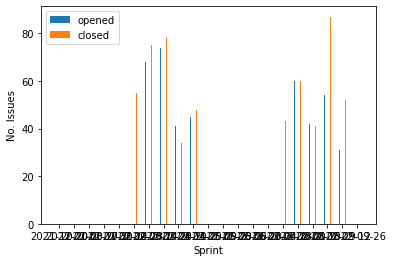

In [20]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index-0.2*sprint_length, issues_focus['opened'], width=0.4)
pyplot.bar(issues_focus.index+0.2*sprint_length, issues_focus['closed'], width=0.4)
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
axes.legend(['opened', 'closed'])
print() # silence output from command before

In [ ]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index-0.2, issues_focus['opened'], width=0.4)
pyplot.bar(issues_focus.index+0.2, -issues_focus['closed'], bottom=issues_focus['opened'], width=0.4)
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
axes.legend(['opened', 'closed'])
print() # silence output from command before

In [ ]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index, issues_focus['open_at_start'])
axes.set_xlabel("Sprint")
axes.set_ylabel("No. Issues")
axes.set_xticks(issues_focus.index)
axes.legend(['open_at_start'])
print() # silence output from command before

In [ ]:
for sprint in range(55, 64+1):
    open = issues_dataframe[issues_dataframe.apply(lambda x: date_to_sprint(x.issue.created_at) < sprint and ((x.issue.closed_at is None) or (date_to_sprint(x.issue.closed_at) >= sprint)), axis=1)]
    open = open.apply(lambda x: [x.issue.number, x.issue.title], axis=1)
    print('Sprint: '+str(sprint)+': ')
    print(open.values)

In [ ]:
figure, axes = pyplot.subplots()
pyplot.bar(issues_focus.index, issues_focus['opened'])
pyplot.bar(issues_focus.index, issues_focus['closed'], bottom=issues_focus['opened'])
axes.set_xticks(issues_focus.index)
axes.legend(['opened', 'closed'])
print() # silence output from command before

# Experiment Zone

In [ ]:
list(map(lambda x: [x.event, x.label], server_repo.get_issue(1).get_events()))

In [ ]:
events = list(server_repo.get_issue(1).get_timeline())
events

In [ ]:
list(map(lambda x: [x.event, x.source, x.node_id], events))

In [ ]:
figure, axes = pyplot.subplots()
c = ['a', 'b', 'a']
colors = numpy.linspace(0, 1, len(numpy.unique(c)))
colordict = dict(zip(c, colors))  
color_col = list(map(lambda x: colordict[x], c))
axes.scatter([1, 2, 3], [1, 2, 3], c=color_col)

In [ ]:
events = []
for issue in issues_raw:
    if issue.created_at >= datetime(2022, 1, 1):
        events.extend(map(lambda event: (issue.number, event), issue.get_timeline()))
events[0:100]

In [ ]:
create_events = map(lambda issue: ({'issue': issue.number, 'time': issue.created_at, 'event': 'created'}),filter(lambda issue: issue.created_at >= datetime(2022, 1, 1), issues_raw))
create_events

In [ ]:
events_dataframe = pandas.DataFrame.from_records([[tup[0], tup[1].created_at, tup[1].event] for tup in events], columns=['issue', 'time', 'event'])
events_dataframe = events_dataframe.append(pandas.DataFrame.from_records(create_events, columns=['issue', 'time', 'event']))
events_dataframe

In [ ]:
numpy.unique(events_dataframe.event)

In [ ]:
event_whitelist = ['created', 'committed', 'review_requested', 'labeled', 'commented', 'cross-referenced', 'closed', 'ready_for_review', 'reviewed', 'milestoned', 'merged', 'assigned', 'referenced', 'mentioned']
events_filtered = events_dataframe[events_dataframe.apply(lambda x: x.event in event_whitelist, axis=1)]
palette = dict(zip(event_whitelist, seaborn.color_palette(n_colors=len(event_whitelist))))

In [ ]:
pyplot.figure(figsize=(20, 10))
seaborn.scatterplot(data=events_filtered, x='time', y='issue', hue='event', palette=palette)

In [ ]:
events_focus = events_filtered[events_filtered.apply(lambda x: x.time >= datetime(2022, 4, 15) and x.time <= datetime(2022, 5, 15),  axis=1)]
pyplot.figure(figsize=(20, 10))
seaborn.scatterplot(data=events_focus, x='time', y='issue', hue='event', palette=palette)